# 필요 라이브러리 import

In [4]:
import os
import urllib.request
import tarfile
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import random as r
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from copy import deepcopy

import argparse
import seaborn as sns

# 데이터 다운로드

- images와 annotation이 나누어져 있으므로 혼동하지 않게 파일을 나누어서 저장

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
IMAGE_URL = "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz"
LABEL_URL = "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz"
DATA_DIR = "./data"

def download_data(url, dest_dir):
    # 디렉토리 생성
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    #IMAGE_URL과 LABEL_URL을 나누어 다른 이름으로 저장 및 압축 해제
    if url == IMAGE_URL:
        tar_path = os.path.join(dest_dir, "images.tar.gz")
    else:
        tar_path = os.path.join(dest_dir, "annotations.tar.gz")

    # 다운로드 수행
    if not os.path.exists(tar_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, tar_path)
        print("Download complete.")

    # 압축 해제
    print("Extracting dataset...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=dest_dir)
    print("Extraction complete.")

In [7]:
download_data(IMAGE_URL, DATA_DIR)
download_data(LABEL_URL, DATA_DIR)

Download complete.
Extracting dataset...
Extraction complete.
Download complete.
Extracting dataset...
Extraction complete.


# 커스텀데이터셋 작성

- init에서 데이터 이름과 정답값을 self.data에 저장함
- getitem에서 self.data를 이용해 ./images파일에서 같은 이름을 찾아 정답값과 함께 반환하도록 커스텀데이터셋 작성
- 이미지 크기가 각각 다른 데이터셋이므로 Resize등 데이터 전처리 실시
- 훈련 데이터셋과 검증 데이터셋을 9 : 1 비율로 나누어 저장

In [8]:
class CustomIIIT(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):

        self.img_dir = img_dir
        self.transform = transform
        self.data = []

        with open(annotations_file, "r") as file:
            # 첫 6줄은 데이터 설명이므로 제외한 나머지 활용
            lines = file.readlines()[6:]
            for line in lines:
                parts = line.strip().split()
                image_name = parts[0] + ".jpg"
                class_id = int(parts[1])-1  # 클래스 범주 1~37 -> 0~36
                self.data.append((image_name, class_id))

    # 데이터 개수 반환
    def __len__(self):
        return len(self.data)

    # 데이터 이름을 이용해 이미지를 찾고 라벨값과 함께 반환
    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype = torch.long)

        return image, label

In [9]:
transform=transforms.Compose([
    transforms.Resize((224, 224)), # 같은 사이즈로 전처리
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor()
  ])

train_dataset = CustomIIIT(
    annotations_file="./data/annotations/trainval.txt",
    img_dir="./data/images",
    transform=transform
)


train_num = int(len(train_dataset)*0.9)
val_num = len(train_dataset) - train_num
train_dataset, validation_dataset = random_split(train_dataset, [train_num, val_num])

test_dataset = CustomIIIT(
    annotations_file="./data/annotations/test.txt",
    img_dir="./data/images",
    transform=transform
)

partition = {'train': train_dataset, 'val':validation_dataset, 'test':test_dataset}

classes = ('Abyssinian', 'american_bulldog','american_pit_bull_terrier',
           'basset_hound', 'beagle', 'Bengal',
           'Birman', 'Bombay', 'boxer',
           'British_Shorthair', 'chihuahua', 'Egyptian_Mau',
           'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
           'great_pyrenees', 'havanese', 'japanese_chin',
           'keeshond', 'leonberger', 'Maine_Coon',
           'miniature_pinscher', 'newfoundland', 'Persian',
           'pomeranian', 'pug', 'Ragdoll',
           'Russian_Blue', 'saint_bernard', 'samoyed',
           'scottish_terrier', 'shiba_inu', 'Siamese',
           'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier',
           'yorkshire_terrier')

print(f"trainset : {len(train_dataset)}")
print(f"validationset : {len(validation_dataset)}")
print(f"testset : {len(test_dataset)}")

trainset : 3306
validationset : 368
testset : 3663


# 데이터 및 라벨링 시각화
tensor : (channel, height, width)

numpy : (height, width, channel)

형식이 서로 다르므로 permute함수로 차원을 교환한 후에 시각화하였다.

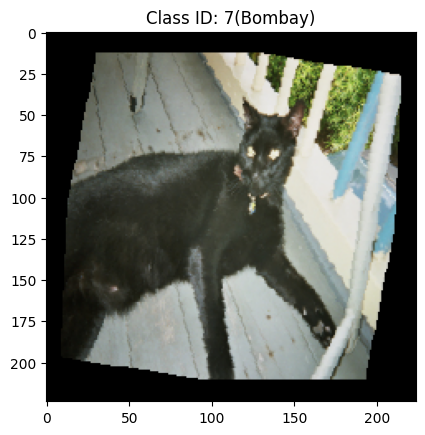

In [10]:
idx = r.randint(0, len(test_dataset))
image, class_id = test_dataset[idx]
image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f"Class ID: {class_id}({classes[class_id]})")
plt.show()

# 모델 구성

In [11]:
def conv_1x1(in_channels, out_channels, stride = 1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 1,
        stride = stride,
        bias = False
    )


def conv_3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = stride,
        padding = 1,
        bias = False
    )

In [12]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()

        self.conv1 = conv_3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = conv_3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 37, zero_init_residual=False):
        super(ResNet, self).__init__()


        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        #함수를 이용해 레이어 생성
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride = 2)

        self.avgpool = nn.AvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    #레이어 생성 함수
    def _make_layer(self, block, out_channels, blocks, stride = 1):
        downsample = None

        # 다운샘플링 조건 설정
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv_1x1(self.in_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [15]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=37)
x = torch.randn(1, 3, 224, 224)
output = model(x)
print(output.shape)


torch.Size([1, 37])


# Train

In [16]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# Validation

In [17]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# Test

In [18]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

# experiment

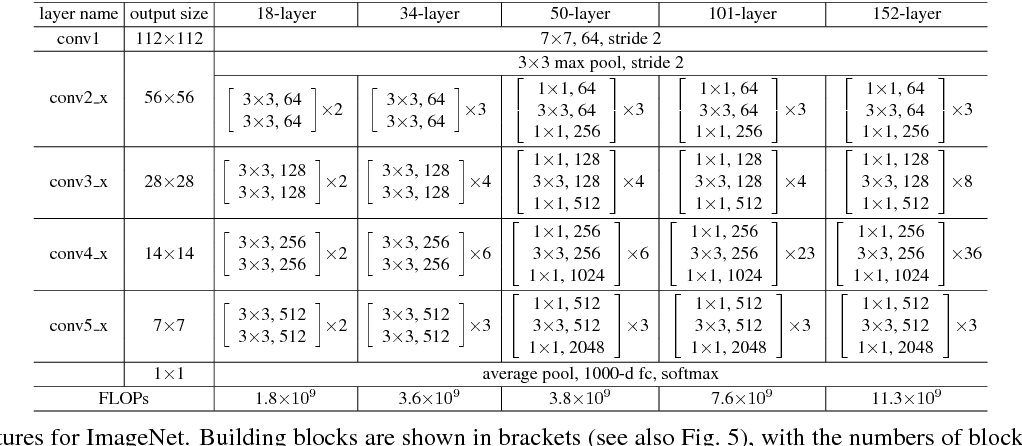

중간 레이어들을 2개씩만 사용하는 가장 가벼운 Resnet18 모델을 이용하였는데,

학습 가능한 데이터 양이 적기 때문에 무거운 신경망을 이용하면 학습 데이터에 지나치게 의존하여 일반화 성능이 떨어질 것이라 생각했습니다.

In [19]:
def experiment(partition, args):

    net = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=37)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2, momentum=0.9)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return result

# 학습

- epoch : 30
- 활성화함수 : SGD
  - learning rate : 0.04
  - weight decay = 0.00001
- batch_size = 256

In [20]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.optim = 'SGD'
args.lr = 0.04
args.epoch = 30
args.l2 = 0.00001

args.train_batch_size = 256
args.test_batch_size = 512

result = experiment(partition, deepcopy(args))

Epoch 0, Acc(train/val): 2.84/2.17, Loss(train/val) 3.69/3.66. Took 28.25 sec
Epoch 1, Acc(train/val): 3.66/2.17, Loss(train/val) 3.67/3.74. Took 26.53 sec
Epoch 2, Acc(train/val): 5.63/4.89, Loss(train/val) 3.59/4.96. Took 28.44 sec
Epoch 3, Acc(train/val): 7.68/5.98, Loss(train/val) 3.46/4.59. Took 23.24 sec
Epoch 4, Acc(train/val): 11.13/4.89, Loss(train/val) 3.31/4.69. Took 29.56 sec
Epoch 5, Acc(train/val): 13.34/5.71, Loss(train/val) 3.17/6.89. Took 28.90 sec
Epoch 6, Acc(train/val): 16.61/7.34, Loss(train/val) 3.04/4.57. Took 24.71 sec
Epoch 7, Acc(train/val): 17.88/8.42, Loss(train/val) 2.92/5.18. Took 23.35 sec
Epoch 8, Acc(train/val): 21.02/7.88, Loss(train/val) 2.80/4.65. Took 28.93 sec
Epoch 9, Acc(train/val): 22.81/13.59, Loss(train/val) 2.76/3.69. Took 24.50 sec
Epoch 10, Acc(train/val): 26.56/13.04, Loss(train/val) 2.63/3.78. Took 27.07 sec
Epoch 11, Acc(train/val): 29.64/5.16, Loss(train/val) 2.50/6.70. Took 25.78 sec
Epoch 12, Acc(train/val): 33.15/10.87, Loss(train/va

# 학습 결과 시각화

In [23]:
def plot_accuracy(result):

    epochs = list(range(len(result['train_accs'])))
    test_acc = result['test_acc']

    sns.set_style("darkgrid")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=result['train_accs'], label='Train Accuracy', marker='o')
    sns.lineplot(x=epochs, y=result['val_accs'], label='Validation Accuracy', marker='s')

    plt.text(0.05, 0.95, f"Test Accuracy: {test_acc:.2f}%",
             horizontalalignment='left', verticalalignment='center',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.3"))

    plt.title('Accuracy by Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()

    plt.show()

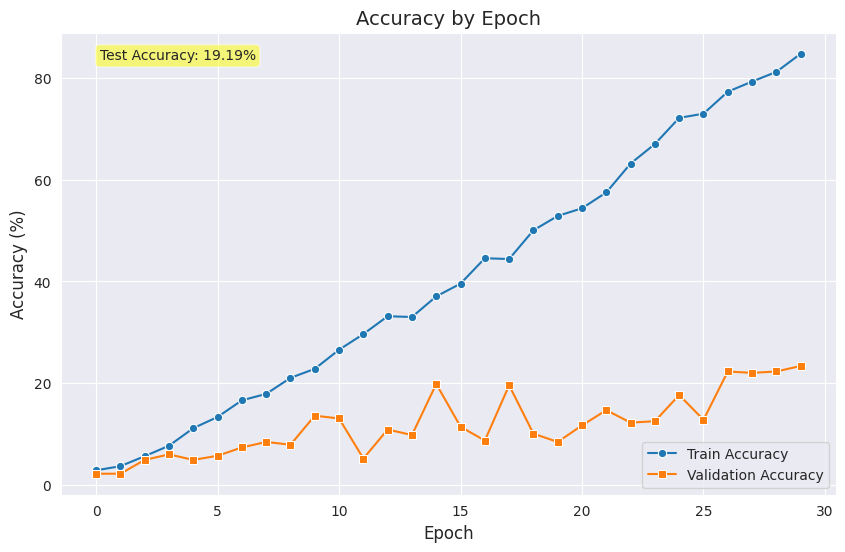

In [24]:
plot_accuracy(result)

# 보고서

## 1. IIIT-Pet Dataset

- 강아지 25품종, 고양이 12품종, 총 37 클래스를 가지는 데이터셋

- 전체 약 7300장을 가지며 각 품종 당 약 200장의 이미지를 가집니다.

- train set과 test set이 각각 약 3600장을 가지며 여기에서는 train set과 validation set을 9 : 1로 나누어 실험 하였습니다.

- 활용
  - 이미지 분류 : 품종 라벨 데이터 존재
  - 객체 탐지 : 바운딩 박스 좌표 파일 존재
  - 이미지 세그멘테이션 : 세그멘테이션 마스크 파일 존재

## 2. 실험 과정

- 커스텀 데이터셋 제작
  - 이미지와 정답값을 직접 다운로드 받아야 합니다.
  - annotation 폴더 내에 여러가지로 활용 가능한 파일들이 있었기 때문에 이미지 분류 문제 해결을 위해 이미지와 품종 라벨을 연결시킬 필요가 있었습니다.
  - 데이터셋의 이미지들의 크기가 서로 달라 Resize함수를 이용해 일정하게 만들었고, randomRotate, randomAffine등의 전처리를 진행했습니다.
- 모델 제작
  - BN과 skip-connection을 포함한 기존 ResNet18모델에서 dropout항을 추가하는 방식으로 제작했습니다.
  - 기존 모델은 skip-connection, BN을 포함하며 dropout비율이 0.5, learning rate가 0.04인 모델이며 각 요소를 변경하며 실험해 보았습니다.
    1. 기존 모델
    2. skip-connection 미포함
    3. BN 미포함
    4. dropout비율 변화 (0.5 -> 0.1)
    5. learning rate 변화 (0.04 -> 0.08)

## 3. 실험 결과





1. 기존 모델 (skip-connection, BN 포함, dropout비율 0.5인 경우)

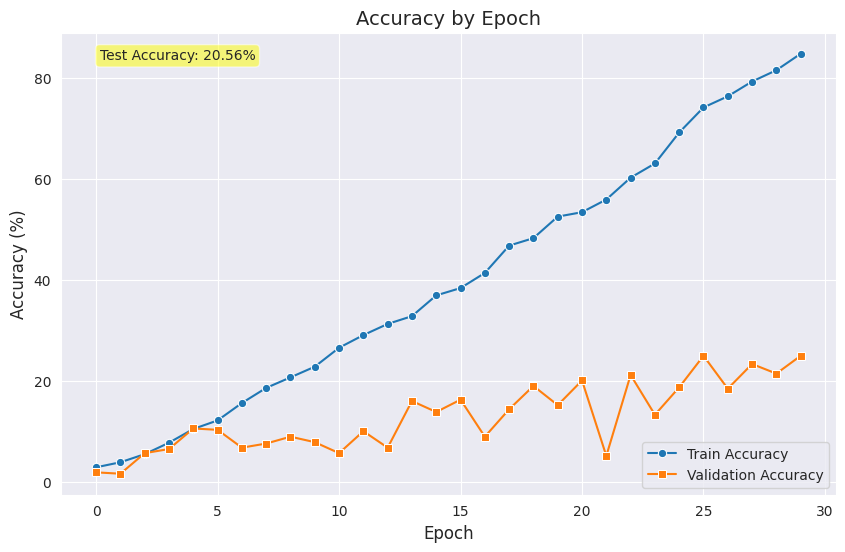

2. skip-connection을 미포함한 경우

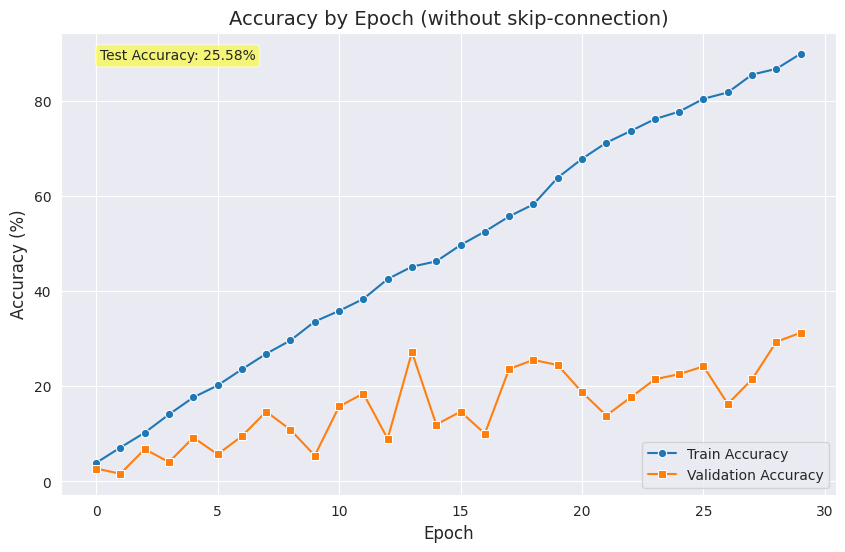

3. BN을 미포함한 경우

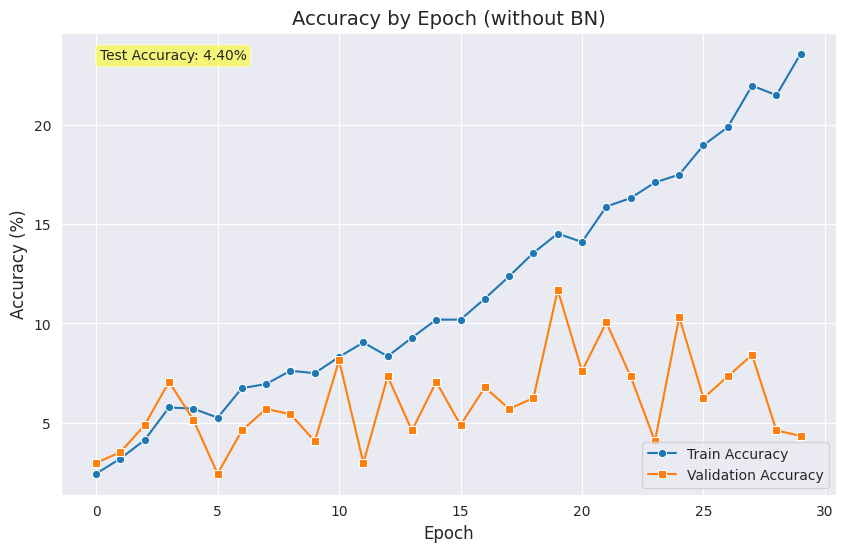

4. dropout비율을 0.1로 낮췄을 경우

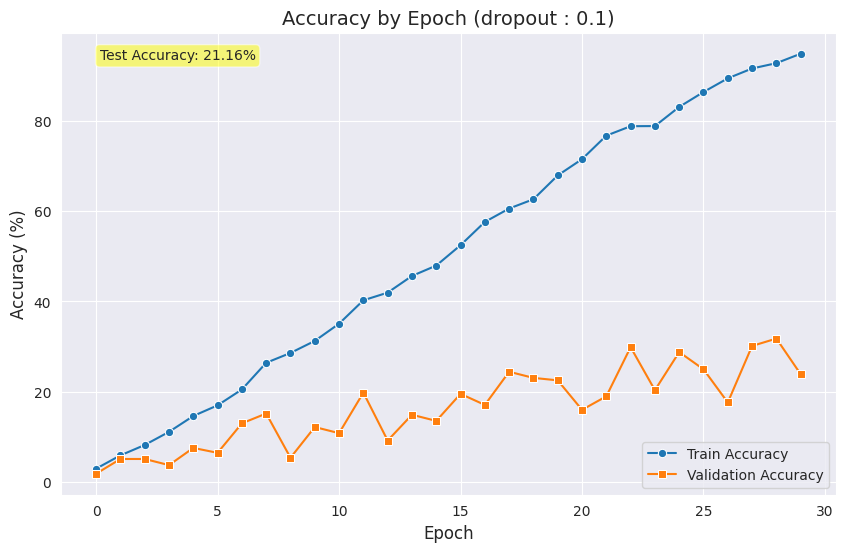

5. learning rate를 0.8로 올린 경우

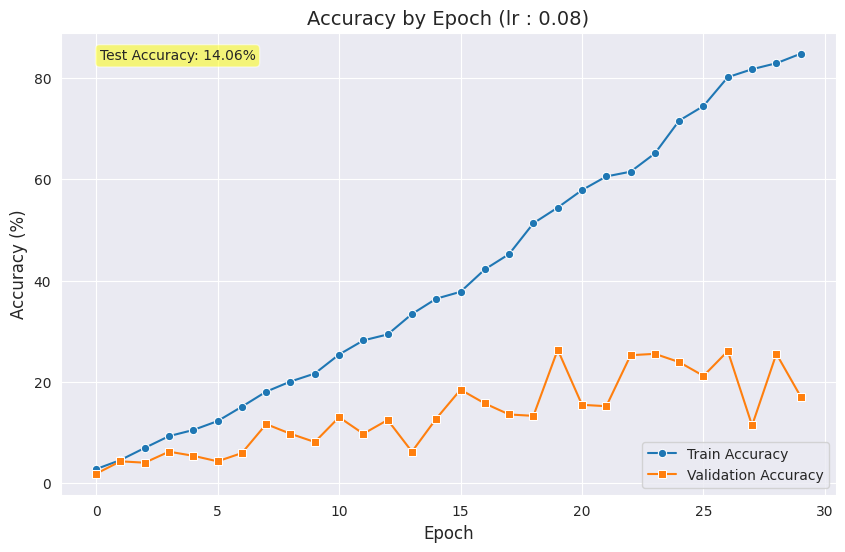

## 4. 실험 분석 및 고찰

- 결과 분석
  - 전체적으로 과적합이 일어났으며 테스트 정확도가 약 20%라는 것을 볼 수 있었습니다.
  - 특이사항으로는 BatchNorm을 제거한 경우에는 훈련 데이터 또한 학습이 거의 일어나지 않은 것을 볼 수 있었습니다.

- 결과 고찰
  - 여러가지 요소들을 변경하며 일반화 성능의 변화를 관찰하였지만 큰 변화가 없다는 것을 알 수 있었습니다.
  - 학습할 데이터셋이 너무 적었고 그에 반해 네트워크가 너무 깊어 일반적인 특징을 잘 찾아내지 못한 것이 원인이라고 생각합니다.
  - 또한 BN을 제거하였을 때는 기울기 소실 문제가 일어나서 학습 자체가 이루어지지 않았다고 볼 수 있습니다.
  - 데이터 증강을 통해 데이터를 늘리고, 모델의 크기를 줄여 다시 실험하면 일반화 성능을 높일 수 있다고 생각합니다.